# Overview

In this tutorial, we train a LSTM model to predict the number of non-emergency calls in San Francisco based on the call category (e.g. <em>Tree Maintenance</em>).

In [1]:
%%capture

# Installing the required libraries:
!pip install matplotlib pandas scikit-learn tensorflow pyarrow tqdm
!pip install google-cloud-bigquery google-cloud-bigquery-storage

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from google.cloud import bigquery
from sklearn import metrics, preprocessing

# Configurations
%matplotlib inline

### Authentication
In order to run this tutorial successfully, we need to be authenticated first. 

Depending on where we are running this notebook, the authentication steps may vary:

| Runner      | Authentiction Steps |
| ----------- | ----------- |
| Local Computer      |  Use a service account, or run the following command: <br><br>`gcloud auth login`    |
| Colab   | Run the following python code and follow the instructions: <br><br>`from google.colab import auth` <br> `auth.authenticate_user()     `    |
| Vertext AI (Workbench)   | Authentication is provided by Workbench       |

In [3]:
try:
    from google.colab import auth

    print("Authenticating in Colab")
    auth.authenticate_user()
    print("Authenticated")
except:  # noqa
    print("This notebook is not running on Colab.")
    print("Please make sure to follow the authentication steps.")

This notebook is not running on Colab.
Please make sure to follow the authentication steps.


### Configurations

Let's make sure we enter the name of our GCP project in the next cell.

In [24]:
# ENTER THE GCP PROJECT HERE
GCP_PROJECT = "endromodal"
print(f"GCP_PROJECT is set to {GCP_PROJECT}")

# Just a list of few existing categories:
sample_categories = [
    "Street and Sidewalk Cleaning",
    "Encampments",
    "Litter Receptacles",
    "Tree Maintenance",
    "Sewer Issues",
    "Muni Service Feedback",
]

GCP_PROJECT is set to endromodal


### Helper Functions

Helper functions needed in this notebook

In [29]:
def create_input_output_datasets(timeseries: np.array, width: int = 5):
    """
    Given a time series, create a matrix as the input
    for the training and a vector as the output.
    """
    data_x, data_y = [], []
    for i in range(len(timeseries) - width - 1):
        data_x.append(timeseries[i: (i + width), 0])
        data_y.append(timeseries[i + width, 0])
    return np.array(data_x), np.array(data_y)

## Data Preparation

### Query the Data

In [5]:
QUERY = """
WITH
  intermediate1 AS (
  SELECT
    DATE_DIFF(created_date, CURRENT_TIMESTAMP(), DAY) AS days_ago,
    category,
  FROM
    `bigquery-public-data.san_francisco_311.311_service_requests`
  WHERE
    latitude > 35
    AND longitude < -122 ),
  intermediate2 AS (
  SELECT
    DIV(days_ago - MIN(days_ago) OVER(), 7) AS week,
    category
  FROM
    intermediate1)
SELECT
  category,
  week,
  COUNT(*) AS count
FROM
  intermediate2
GROUP BY
  category,
  week;
"""

In [6]:
bqclient = bigquery.Client(project=GCP_PROJECT)
dataframe = bqclient.query(QUERY).result().to_dataframe()

### Check the Dataframe



In [7]:
print(dataframe.shape)
dataframe.head()

(26022, 3)


,category,week,count
0,Muni Employee Feedback,641,118
1,Muni Employee Feedback,689,97
2,Muni Service Feedback,638,71
3,Shared Spaces Violation,701,18
4,Muni Service Feedback,704,75


In [8]:
CATEGORY = sample_categories[3]
print(f"Selected category: {CATEGORY}")

Selected category: Tree Maintenance


### Prepare the Data for Training

For the selected category above, we create a weekly time series based on number of calls that category has received in a given week:

In [9]:
category_df = dataframe[dataframe["category"] == CATEGORY]
max_week = category_df["week"].max()
min_week = category_df["week"].min()
# Some weeks may have no data, in which case we will set the value to zero.
category_timeseries = np.zeros(max_week - min_week + 1)
for index, row in category_df.iterrows():
    category_timeseries[row["week"] - min_week] = row["count"]
category_timeseries = category_timeseries.reshape(-1, 1)
print(f"Length of the time series: {len(category_timeseries)}")

Length of the time series: 708


We then normalize the time series to ensure all values are between 0 and 1.

In [10]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
nrm_timeseries = scaler.fit_transform(category_timeseries)

We split the time series into two partitions for training and testing.

In [11]:
TRAIN_RATIO = 0.8
train_size = int(len(nrm_timeseries) * TRAIN_RATIO)
test_size = len(nrm_timeseries) - train_size
train_timeseries = nrm_timeseries[0:train_size, :]

test_timeseries = nrm_timeseries[train_size: len(nrm_timeseries), :]
print(f"Training Size: {len(train_timeseries)}")
print(f"Test Size: {len(test_timeseries)}")

Training Size: 566
Test Size: 142


Next, we need to create an input matrix and an output vector from our normalized time series. Here is an example:

Let's assume we have the following variables:
```
timeseries = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
width = 3
```

The matrix and the vector will then be:

```
matrix = [[0.1, 0.2, 0.3],
          [0.2, 0.3, 0.4],
          [0.3, 0.4, 0.5]]

vector = [0.4, 0.5, 0.6]
```

The `width` can help us determine how many weeks in the time series we want to look back to make a prediction about the next week.

In the example above, we want to predict a new entry by looking back at the previous 3 weeks.

Let's create the input and output for both training and test time series.

In [13]:
# Determining how far back we want to look at
# the data to make prediction about the next entry
WEEKS_BACK = 3

train_x, train_y = create_input_output_datasets(train_timeseries, WEEKS_BACK)
test_x, test_y = create_input_output_datasets(test_timeseries, WEEKS_BACK)

Finally, we need to reshape input with the  `[samples, time_steps, features]` dimensions where `time_steps = 1`.

In [14]:
# reshape input to be [samples, time steps, features]
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

## Train the Model

Now that our data is prepared, we can build and train the model. Here is a simple LSTM model.

We should not need a GPU to train this model since our training dataset is not too big.


In [15]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(10, input_shape=(1, WEEKS_BACK)))
model.add(tf.keras.layers.Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(train_x, train_y, epochs=5, batch_size=1, verbose=1);

Epoch 1/5
562/562 [==============================] - 1s 907us/step - loss: 0.0026
Epoch 2/5
562/562 [==============================] - 0s 800us/step - loss: 0.0020
Epoch 3/5
562/562 [==============================] - 0s 792us/step - loss: 0.0015
Epoch 4/5
562/562 [==============================] - 0s 775us/step - loss: 0.0020
Epoch 5/5
562/562 [==============================] - 0s 782us/step - loss: 0.0016


## Evaluate the Model

With the trained model, we can create predictions for both training and test datasets and evaluate the results.

In [16]:
train_pred = model.predict(train_x)
test_pred = model.predict(test_x)

Since we previously normalized our time series, we need to inverse that step now that we have prediction results.

In [17]:
train_pred = scaler.inverse_transform(train_pred)
train_y = scaler.inverse_transform([train_y])
test_pred = scaler.inverse_transform(test_pred)
test_y = scaler.inverse_transform([test_y])

Let's evaluate the results for both training and test datasets. We use the Root Mean Squared Error for both cases.

In [23]:
train_score = np.sqrt(metrics.mean_squared_error(train_y[0], train_pred[:, 0]))
print(f"Train Score: {train_score:0.2f} RMSE")

test_score = np.sqrt(metrics.mean_squared_error(test_y[0], test_pred[:, 0]))
print(f"Test Score: {test_score:0.2f} RMSE")

Train Score: 49.79 RMSE
Test Score: 107.21 RMSE


To plot the results, let's first shift both predictions to their right spot on the X-axis.

In [19]:
# shift train predictions for plotting
train_pred_plot = np.empty_like(nrm_timeseries)
train_pred_plot[:, :] = np.nan
train_pred_plot[WEEKS_BACK: len(train_pred) + WEEKS_BACK, :] = train_pred

# shift test predictions for plotting
test_pred_plot = np.empty_like(nrm_timeseries)
test_pred_plot[:, :] = np.nan
test_pred_plot[
    len(train_pred) + (WEEKS_BACK * 2) + 1: len(nrm_timeseries) - 1, :
] = test_pred

Finally, we can plot the results of the prediction.

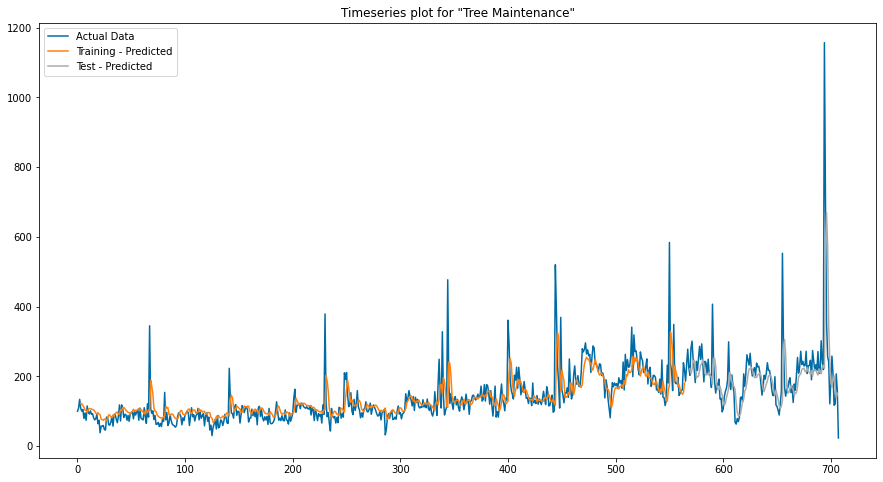

In [20]:
# plot baseline and predictions
plt.figure(figsize=(15, 8))
plt.style.use("tableau-colorblind10")
plt.plot(category_timeseries, label="Actual Data")
plt.plot(train_pred_plot, label="Training - Predicted")
plt.plot(test_pred_plot, label="Test - Predicted")
plt.legend(loc="upper left")
plt.title(f'Timeseries plot for "{CATEGORY}"')
plt.show()

The result seems reasonable. As a practice, you may want to try another categoty or change the `weeks_back` parameter and see the performance of different models.